<td>
   <a target="_blank" href="https://labelbox.com" ><img src="https://labelbox.com/blog/content/images/2021/02/logo-v4.svg" width=256/></a>
</td>

<td>
<a href="https://colab.research.google.com/github/Labelbox/labelbox-python/blob/develop/examples/model_assisted_labeling/tiled_imagery_mal.ipynb" target="_blank"><img
src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
</td>

<td>
<a href="https://github.com/Labelbox/labelbox-python/tree/develop/examples/model_assisted_labeling/tiled_imagery_mal.ipynb" target="_blank"><img
src="https://img.shields.io/badge/GitHub-100000?logo=github&logoColor=white" alt="GitHub"></a>
</td>

# Tiled Imagery MAL

* Upload model inferences on tile imagery
* The example in the notebook uses a heuristic to prelabel water in the imagery

In [1]:
!pip install -q 'labelbox[data]'

In [1]:
import os

import uuid
import numpy as np
from PIL import Image
import cv2
import ndjson

from labelbox.data.annotation_types.data.tiled_image import TiledBounds, TiledImageData, TileLayer, EPSG, EPSGTransformer
from labelbox.data.serialization.ndjson.converter import NDJsonConverter
from labelbox.data.annotation_types import Point, Polygon, Mask, MaskData, Label, ObjectAnnotation
from labelbox.schema.ontology import OntologyBuilder, Tool
from labelbox import Client, LabelingFrontend

In [4]:
# Add your api key
API_KEY = None
client = Client(api_key=API_KEY)

### Project Setup

In [2]:
# We will be creating a simple ontology with one polygon tool.
ontology_builder = OntologyBuilder(
    tools=[Tool(tool=Tool.Type.POLYGON, name="water")])

In [2]:
# This notebook only uploads data for a single dataRow.

# Select the region to label within the image
top_left_bound = Point(x=-122.31764674186705, y=37.87276155898985)
bottom_right_bound = Point(x=-122.31635199317932, y=37.87398109727749)

epsg = EPSG.EPSG4326
bounds = TiledBounds(epsg=epsg, bounds=[top_left_bound, bottom_right_bound])
tile_layer = TileLayer(
    url=
    "https://public-tiles.dronedeploy.com/1499994155_DANIELOPENPIPELINE_ortho_qfs/{z}/{x}/{y}.png?Policy=eyJTdGF0ZW1lbnQiOlt7IlJlc291cmNlIjoiaHR0cHM6Ly9wdWJsaWMtdGlsZXMuZHJvbmVkZXBsb3kuY29tLzE0OTk5OTQxNTVfREFOSUVMT1BFTlBJUEVMSU5FX29ydGhvX3Fmcy8qIiwiQ29uZGl0aW9uIjp7IkRhdGVMZXNzVGhhbiI6eyJBV1M6RXBvY2hUaW1lIjoyMTQ1OTE0MTE4fX19XX0_&Signature=O~50rrGXdEC6Hi8jPJ3dbT~UtBd7Cw6iQPTxdJ8LU2IaoxeP22R3JpKPkLN3T3~Lcw3CyX7uft2Baj0MH93qUoCYyN~~jNX3OMkYV2jbrHDezf6zQRHAabXX-L2bL-JEGfFL6z3DWccOFeCH56CuhgC29k5CJx7I34P-LQJdnAUsA-KaqKH1IyYsHStRIfmMzdXNAWU58FTfqVljq9SbKXxfgdr2SZ~7VgLaZ8IhA0WnlKUo-JgqTd~jYa5mGCpR8351IMK0aMuY4Mld4SOXssQ-rOtlZtypvo8FDp474TlGIEGz5PHxGOPsqLPF19hEYTgoPqsUj8QEuiTfg-cmsg__&Key-Pair-Id=APKAJXGC45PGQXCMCXSA"
)

tiled_image_data = TiledImageData(tile_layer=tile_layer,
                                  tile_bounds=bounds,
                                  zoom_levels=[17, 23])

In [7]:
# Lets setup the project
# Note see Ontology, Project, and Project_setup notebooks for more information on this section.

project = client.create_project(name="tms_mal_project")
dataset = client.create_dataset(name="tms_mal_dataset")

# DataRows can only be created as bulk operations for tiled imagery data
dataset.create_data_rows([tiled_image_data.asdict()])
editor = next(
    client.get_labeling_frontends(where=LabelingFrontend.name == "Editor"))
project.setup(editor, ontology_builder.asdict())
project.datasets.connect(dataset)

* <b>Grab featureSchemaIds</b>
* This enables us to assign model inferences to a specific class in labelbox
* Checkout the ndjson section to see where this is used

In [8]:
# When we created a project with the ontology defined above, all of the ids were assigned.
# Let's reconstruct the ontology builder with all of the ids.
ontology = ontology_builder.from_project(project)
# We want all of the feature schemas to be easily accessible by name.
schema_lookup = {tool.name: tool.feature_schema_id for tool in ontology.tools}
print(schema_lookup)

{'water': 'cky3ajgh59g8m0z9t8dy91rlo'}


### Create import objects
* We want to create a polygon json payload that matches the format documented here : https://docs.labelbox.com/data-model/en/index-en#polygon

* <b>Visualize tile and labeling region</b>

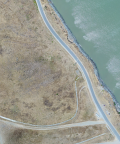

In [3]:
# Visualize the region of interest in the larger tile
image = tiled_image_data.value
Image.fromarray(image)

* <b>Run Model</b>
* This is where users can run model inferences.
* For this example we are detecting water with some simple image processing

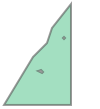

In [4]:
# Mask out pixels that do not belong to water
# Clean up with some postprocessing

# Note that the y axis is different when rendering polygons than it is in images.
# This will appear correctly in labelbox

hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
mask = cv2.inRange(hsv, (50, 10, 25), (100, 150, 255))
Image.fromarray(mask)
kernel = np.ones((5, 5), np.uint8)
mask = cv2.erode(mask, kernel)
mask = cv2.dilate(mask, kernel)

mask_annotation = MaskData.from_2D_arr(mask)
mask_data = Mask(mask=mask_annotation, color=[255, 255, 255])
pixel_polygons = mask_data.shapely.simplify(3)
pixel_polygons

* <b>Convert Mask to WGS84 Polygons<b>

In [7]:
#generate the pixel bounds for our transformer
h, w, _ = image.shape
pixel_bounds = TiledBounds(epsg=EPSG.SIMPLEPIXEL,
                           bounds=[Point(x=0, y=0),
                                   Point(x=w, y=h)])

transformer = EPSGTransformer.create_pixel_to_geo_transformer(
    src_epsg=pixel_bounds.epsg,
    pixel_bounds=pixel_bounds,
    geo_bounds=tiled_image_data.tile_bounds,
    zoom=17)

#transform from pixel space back to EPSG 4326
geo_polygon = transformer(Polygon.from_shapely(pixel_polygons))

* <b>Create NDJson Labels From Geo Polygons</b>

In [14]:
datarow_id = next(dataset.data_rows()).uid
tiled_image_data.uid = datarow_id
label = Label(data=tiled_image_data,
              annotations=[
                  ObjectAnnotation(value=geo_polygon,
                                   name="water",
                                   feature_schema_id=schema_lookup['water'])                                 
              ])

ndjson_labels = list(NDJsonConverter.serialize([label]))

* <b>Upload to Labelbox</b>

In [13]:
# Upload!
upload_task = project.upload_annotations(name=f"upload-job-{uuid.uuid4()}",
                                         annotations=ndjson_labels,
                                         validate=False)

In [14]:
# Wait for upload to finish
upload_task.wait_until_done()
# Review the upload status
print(f"Errors: {upload_task.errors}")

upload_task.statuses